# Rotterdam stylized case

In [1]:
from classes import *
import copy
from collections import OrderedDict
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
#import ipywidgets as widgets
import pickle

import tqdm

from pdb import set_trace

from models import Rotty
from mayors import *

### Load the model with parameters

In [2]:
#global pars (for the development of Trust) Will be removed 
k = 0.2 
T_eq = 70
Rotty

Rotty 
-----------
allFloodProtection: 
No 3.5; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'alarming_conditions': OrderedDict([(1, ['Major flood', 40]), (0, ['Small flood', 20]), (-0.2, ['Near miss', 10]), (-0.4, ['Major wake-up', 7]), (-1, ['Minor wake-up', 5]), (-10, ['Nothing happens', 0])]), 'Gumbel': OrderedDict([('mu', 2.33), ('beta', 0.234)]), 'I_experience_interp': {'xp': [0, 0.5], 'fp': [0, 1]}, 'I_social': 1}

### Load storm surge scenarios

In [3]:
# Load all SLR_Scenario
allSLR_Scenario = SLR_Scenario_from_pickles(os.path.join("SLR_projections","Transients"))

#for filename in os.listdir("SLR_projections"):
#    if filename.endswith(".csv"):
#        obj = SLR_Scenario(filename.split('.')[0]) #Init object with name derived from filename
#        obj.from_csv(os.path.join('SLR_projections',filename)) #Fill the object with data from the csv file


# Load all SurgeHeight (Realisations of extreme value distribution)
for filename in os.listdir("SurgeHeight"):
    if filename.endswith(".csv"):
        obj = SurgeHeight(filename.split('.')[0]) #Init object with name derived from filename
        obj.from_csv(os.path.join('SurgeHeight',filename)) #Fill the object with data from the csv file

# Create SurgeLevels by summing combinations of SLR_Scenario and SurgeHeights
for SLR_Scenario in allSLR_Scenario:
    for SurgeHeight in allSurgeHeight:
        combine_SurgeLevel(SLR_Scenario,SurgeHeight)
        
# Print all available SLR scenarios
for SLR_Scenario in allSLR_Scenario:
    print(SLR_Scenario.name,end=' ||| ')

Scenario_01 ||| Scenario_02 ||| Scenario_03 ||| Scenario_04 ||| Scenario_05 ||| Scenario_06 ||| Scenario_07 ||| Scenario_08 ||| Scenario_09 ||| 

### Run this block if you want to focus on a subset of the scenarios

In [4]:
# Make a manual preselection of scenarios to simplify plots
transient = "2"
selection = [x for x in allSurgeLevel if x.name.split("__")[1] == transient] #only run experiments for one of the transients
selected_scens = ['01','03','05','09']
#selection = [x for x in selection if x.name.split('__')[0] in ['SROCC_2019_RCP26_17','SROCC_2019_RCP85_50','SROCC_2019_RCP85_83','Bamber_2019_high_95']]
selection =  [x for x in selection if x.name.split('__')[0].split('_')[1] in selected_scens]
selection

[Scenario_01__2, Scenario_03__2, Scenario_05__2, Scenario_09__2]

### Load adaptation strategies (Mayors)

In [5]:
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

### Model run algorithm

In [6]:
from run_model import run_model01

### Run the behaviour of one Mayor

In [3]:
#run one mayor:
mayor_experiments = []
for SurgeLevel in selection:
    experiment = run_model01(Rotty,SurgeLevel,Economicus(),do_print=True)
    mayor_experiments.append(experiment)
print('experiments finished')

NameError: name 'selection' is not defined

### Plot the results

NameError: name 'mayor_experiments' is not defined

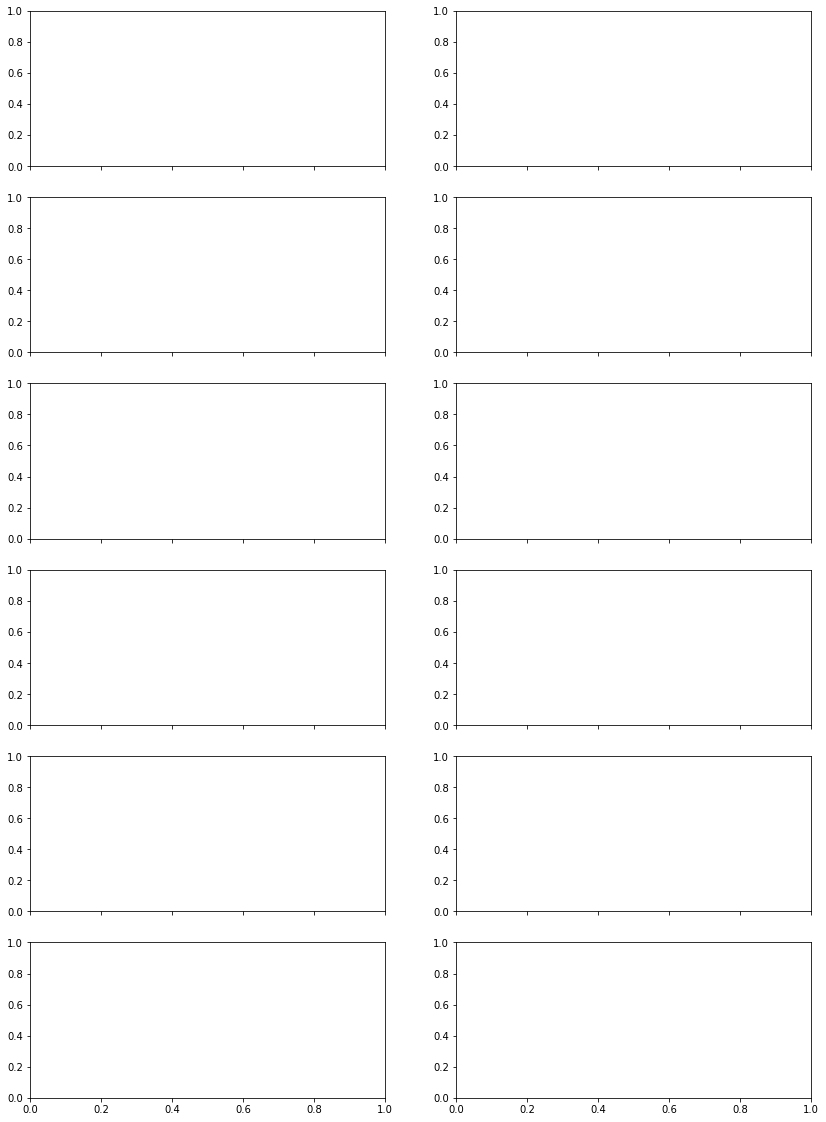

In [2]:
p1 = ['#e66101','#fdb863','#b2abd2','#5e3c99'] #palette
p2 = ['#d7191c','#fdae61','#abd9e9','#2c7bb6']
p3 = ['#d7191c','#fdae61','#abdda4','#2b83ba']
p = p3
p.reverse()

nrows=6
ncols=2

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=False,sharex=True,figsize=(14,20))

labels = []

xlim = (2020,2200)

for j,experiment in enumerate(reversed(mayor_experiments)):
    
    Model = experiment.Model
    SurgeLevel = experiment.SurgeLevel
    Mayor = experiment.Mayor
    
    time = SurgeLevel.years
    
    axes[0,0].plot(time,SurgeLevel.surgelevel,color=p[j])

    labels.append(SurgeLevel.name)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    #axes[0,0].set_xlabel('Time [year]')
    axes[0,0].set_ylabel('Storm surge level [m]')
    axes[0,0].set_ylim(0,12)
    axes[0,1].set_ylim(0,12)
    axes[0,1].set_ylabel('Dike height [m]')
    
    axes[0,0].set_xlim(xlim[0],xlim[1])
    
    axes[0,1].plot(time,Model.allFloodProtection[1].measure_history,'x',color=p[j]) #PLOT THE HISTORY OF THE MEASURES

    for i, Area in enumerate(Model.allResidentialArea):
        axes[0,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
       
           
        #plot damage
        axes[1,i].set_title('Damage {}'.format(Area.name))
        axes[1,i].plot(time,[x*10**(-6) for x in Model.allResidentialArea[i].flood_damage],'o',color=p[j])
        axes[1,i].set_ylabel('Damage [10^6 \u20ac/y]')
        #axes[1,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    
        axes[2,i].set_title('Flood protection of area {}'.format(Model.allResidentialArea[i].name))
        axes[2,i].plot(time,Model.allResidentialArea[i].protection_level_rp,'-',color=p[j])
        axes[2,i].set_yscale("log")
        axes[2,i].set_ylabel('Return period [year]')
        #axes[2,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    
        axes[3,i].set_title('Risk perception coefficient {}'.format(Model.allResidentialArea[i].name))
        axes[3,i].plot(time,Model.allResidentialArea[i].risk_perception,'-',color=p[j])
        axes[3,i].set_ylabel('[-]')
        axes[3,i].set_ylim(0,1)

        #axes[3,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        
        axes[4,i].set_title('Objective and perceived flood risk area {}'.format(Model.allResidentialArea[i].name))
        unit_corr = [x * 10**6 for x in Model.allResidentialArea[i].risk]
        axes[4,i].plot(time,unit_corr,'-',color=p[j])
        axes[4,i].set_yscale("log")
        axes[4,i].set_ylabel('Expected annual damage [\u20ac/y]')
        #axes[4,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        #Manually add legend patches
        custom_lines = [Line2D([0], [0], color='black',label='Objective flood risk',linestyle='-'),
                        Line2D([0], [0], color='black',label='Perceived flood risk',linestyle='--')]
        axes[4,i].legend(handles=custom_lines)
        
        unit_corr2 = [x * 10**6 for x in Model.allResidentialArea[i].risk_perceived]
        axes[4,i].plot(time,unit_corr2,'--',color=p[j])
        
        axes[5,i].set_title('House prices in residential area')
        axes[5,i].plot(time,Area.house_price_t_objective,color=p[j])
        custom_lines = [Line2D([0], [0], color='black',label='Rational house market',linestyle='-'),
                        Line2D([0], [0], color='black',label='Bounded rational house market',linestyle='--')]
        axes[5,i].legend(handles=custom_lines)
        axes[5,i].set_ylim(0,4e5)
        
        
        
        axes[5,i].plot(time,Area.house_price_t_subjective,'--',color=p[j])
        
        #axes[6,i].set_title('Development of trust in {} [DEPRECIATED]'.format(Area.name))
        #axes[6,i].plot(time,Model.allResidentialArea[i].trust_t,color=p[j])
        #axes[6,i].set_ylim(0,100)
    
    axes[0,1].plot(time,Model.allFloodProtection[1].protection_level,color=p[j])
    axes[0,1].set_title('Development of flood protection object Dike')
    
       
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[1,0].set_ylim(-20,80)
    HP = Model.allResidentialArea[0]
    for i,year in enumerate(time[0:xlim[1]-xlim[0]]):
        text = HP.event_history[i]
        if text == "!":
            axes[1,0].text(year,-18 + 7 * j,text,color=p[j],fontsize=8)
            
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[1,1].set_ylim(0,5000)
    CC = Model.allResidentialArea[1]
    for i,year in enumerate(time[0:xlim[1]-xlim[0]]):
        text = CC.event_history[i]
        if text == "!":
            axes[1,1].text(year,0 + 500 * j,text,color=p[j],fontsize=8)

axes[0,0].legend(labels)

axes[0,1].text(0.05,0.2,"Crosses indicate when the (initial) decision was taken \n - Decisions may be overruled by a more transformative measure.",transform=axes[0,1].transAxes)


#PRINT THE THRESHOLD PROTECTION LEVELS FOR THE LAWKEEPER MAYOR
if Mayor.get_name() == 'Lawkeeper':
    axes[2,1].plot(time,[Mayor.threshold_small]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[2,1].plot(time,[Mayor.threshold_large]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[2,1].text(2030,Mayor.threshold_small - 4000,'Threshold small measure',color='black',alpha=1)
    axes[2,1].text(2030,Mayor.threshold_large - 800,'Threshold large measure',color='black',alpha=1)
    
for j in [0,1]:
    alpha = 0.5
    color = 'black'
    axes[3,j].plot(time,[0.5]*len(time),color=color,linestyle='--',alpha = alpha)    
    #Manually add legend patches
    custom_line = [Line2D([0], [0], color=color, alpha=alpha,label='Perceived risk equals objective risk',linestyle='--')]
    axes[3,j].legend(handles=custom_line)
    axes[3,j].text(0.5,0.3,'underestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')
    axes[3,j].text(0.5,0.7,'overestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')


for nr in range(0,nrows):
    for l,letter in enumerate(('A','B')):
        axes[nr,l].text(-0.15, 1.1, "{}{}.".format(nr+1,letter), transform=axes[nr,l].transAxes,
                       fontsize=13, fontweight='bold', va='top')
    
#################################################################    
#################### SAVE THE EXPERIMENT ########################
#################################################################


filename = experiment.Mayor.get_name() + "_trans_" + experiment.SurgeLevel.name.split("__")[1]

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
foldername = date
target = os.path.join('Visualisations',foldername)
if not os.path.exists(target):
    os.mkdir(target)
else:
    print("Target folder {} already exists".format(target))
    
#fig.savefig(os.path.join(target,filename + "_new.png"),bbox_inches='tight',dpi=150)

In [28]:
experiment = mayor_experiments[0]
years = experiment.SurgeLevel.years
Area_B = experiment.Model.allResidentialArea[1]
len(Area_B.flood_history)

280

In [49]:
def year_to_index(year,years = experiment.SurgeLevel.years):
    """
    Give a year, returns the index of this year
    """
    return years.index(year)
i = year_to_index(2101)

# Run all Mayors

In [54]:
from tqdm.notebook import trange, tqdm

In [ ]:
#run all Majors
allExperiments = []
with tqdm(total =len(allSurgeLevel)*len(allMayors)) as pbar:
    for SurgeLevel in allSurgeLevel:
        #print("\n \n {} \n\n------------- \n\n".format(SurgeLevel.name))
        for Mayor in allMayors:
            experiment = run_model01(Rotty,SurgeLevel,Mayor,do_print=False)
            allExperiments.append(experiment)
            pbar.update(1)
print('experiments finished')

### Save EXPERIMENTS as pickle

In [21]:
experiments=allExperiments

foldername = "temp"
subfolder = "experiments"
target = os.path.join(foldername,subfolder)

today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)

if not os.path.exists(foldername):
    os.mkdir(foldername)
    if not os.path.exists(target):
        os.mkdir(target)

pickle.dump(experiments, open( os.path.join(target,"experiment_" + date +  ".p"), "wb") ) 